In [41]:
from IPython.display import clear_output
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data.dataloader as dataloader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [42]:
batch_size = 64
dataset_path = '../data'
epochs_num = 10
learning_rate = 1e-4

In [43]:
gpu_indx = 0
device = torch.device(gpu_indx if torch.cuda.is_available() else 'cpu')

In [44]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST(dataset_path, download=True, train=True, transform=transform)

all_pixels = torch.cat([img[0].view(-1) for img, _ in dataset])

mean = all_pixels.mean()
std = all_pixels.std()

print(f'mean: {mean}')
print(f'std: {std}')

mean: 0.13066047430038452
std: 0.30810782313346863


In [45]:
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([mean.item()], [std.item()])
])

In [46]:
train_dataset = datasets.MNIST(dataset_path, download=True, train=True, transform=transform)
test_dataset = datasets.MNIST(dataset_path, download=True, train=False, transform=transform)

validation_split = 0.9

train_examples_num = int(len(train_dataset) * validation_split)
valid_examples_num = len(train_dataset) - train_examples_num

train_dataset, valid_dataset = torch.utils.data.random_split(
    train_dataset, 
    [train_examples_num, valid_examples_num],
    generator=torch.Generator().manual_seed(42)
)

# The use of a generator with a manually set seed is a key practice in machine learning 
# to ensure that results are reproducible, consistent, and reliable, which is essential 
# for scientific rigor, debugging, and comparing different models or training strategies.

In [47]:
print(f'Number of training examples: {len(train_dataset)}')
print(f'Number of validation examples: {len(valid_dataset)}')
print(f'Number of testing examples: {len(test_dataset)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


In [48]:
train_loader = dataloader.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = dataloader.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = dataloader.DataLoader(test_dataset, batch_size=batch_size)

In [49]:
class LeNet(nn.Module):
    def __init__(self, in_channels):
        super(LeNet, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5)
        self.conv_2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        self.linear_1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.linear_2 = nn.Linear(in_features=120, out_features=84)
        self.linear_3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv_2(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.linear_1(x))
        x = F.relu(self.linear_2(x))
        x = self.linear_3(x)

        return x

In [50]:
data_iter = iter(test_loader)
test_images, test_labels = next(data_iter)
print(test_images.shape)
print(test_labels.shape)

torch.Size([64, 1, 32, 32])
torch.Size([64])


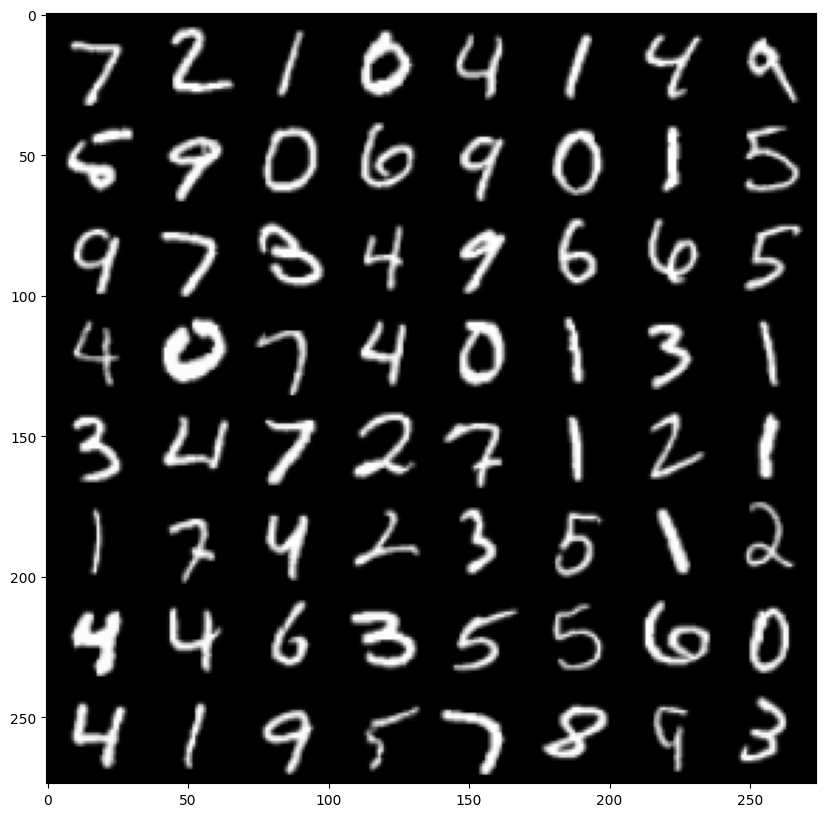

In [51]:
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(test_images, 8, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

In [52]:
model = LeNet(in_channels=test_images.shape[1]).to(device)
print(model)

LeNet(
  (conv_1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv_2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_1): Linear(in_features=400, out_features=120, bias=True)
  (linear_2): Linear(in_features=120, out_features=84, bias=True)
  (linear_3): Linear(in_features=84, out_features=10, bias=True)
)


In [53]:
out = model(test_images.to(device))
print(out.shape)

torch.Size([64, 10])


In [54]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [55]:
def train(model, loader, optimizer,  loss_fun, loss_logger):
    model.train()

    for i, (x, y) in enumerate(tqdm(loader, leave=False, desc="Training")):
        forward_pass = model(x.to(device))
        loss = loss_fun(forward_pass, y.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_logger.append(loss.item())
        
    return model, optimizer, loss_logger

In [56]:
def evaluate(model, loader):
    epoch_accuracy = 0

    model.eval()


    with torch.no_grad():
        for i, (x, y) in enumerate(tqdm(loader, leave=False, desc="Evaluating")):
            forward_pass = model(x.to(device))
            epoch_accuracy += (forward_pass.argmax(1) == y.to(device)).sum().item()

    return epoch_accuracy / len(loader.dataset)

In [57]:
train_loss_logger = []
train_acc_logger = []
valid_acc_logger = []

In [58]:
for epoch in trange(epochs_num, desc="Epochs"):
    model, optimizer, train_loss_logger = train(model, train_loader, optimizer, loss_fn, train_loss_logger)
    
    train_accuracy = evaluate(model, train_loader)
    train_acc_logger.append(train_accuracy)
    
    valid_accuracy = evaluate(model, valid_loader)
    valid_acc_logger.append(valid_accuracy)
    clear_output(wait=True)

Text(0.5, 1.0, 'LeNet Training Loss')

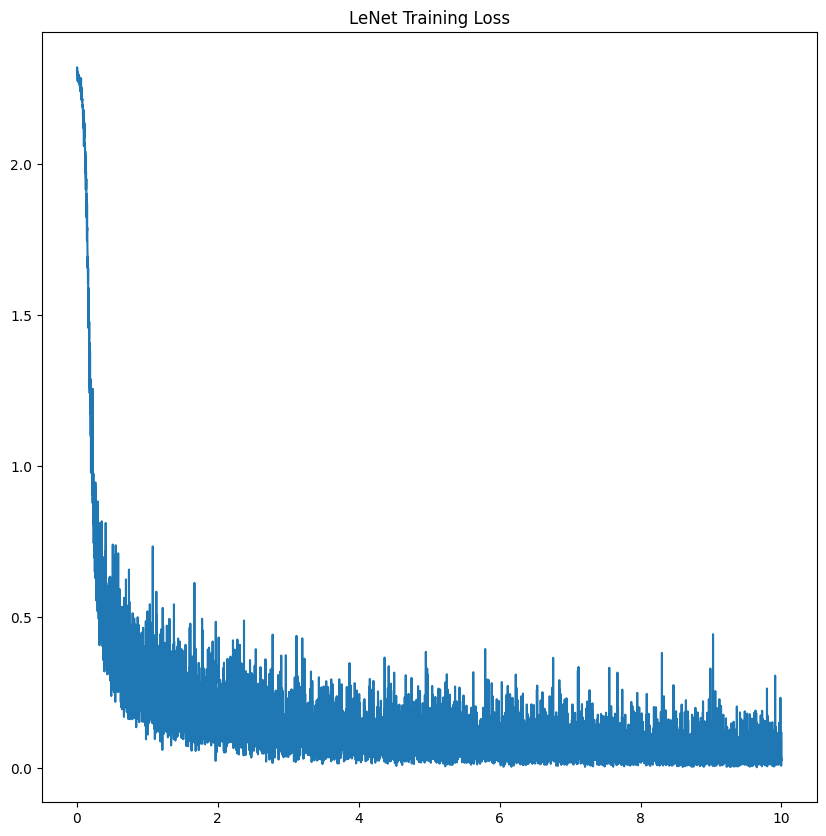

In [59]:
plt.figure(figsize = (10,10))
train_x = np.linspace(0, epochs_num, len(train_loss_logger))
plt.plot(train_x, train_loss_logger)
plt.title("LeNet Training Loss")

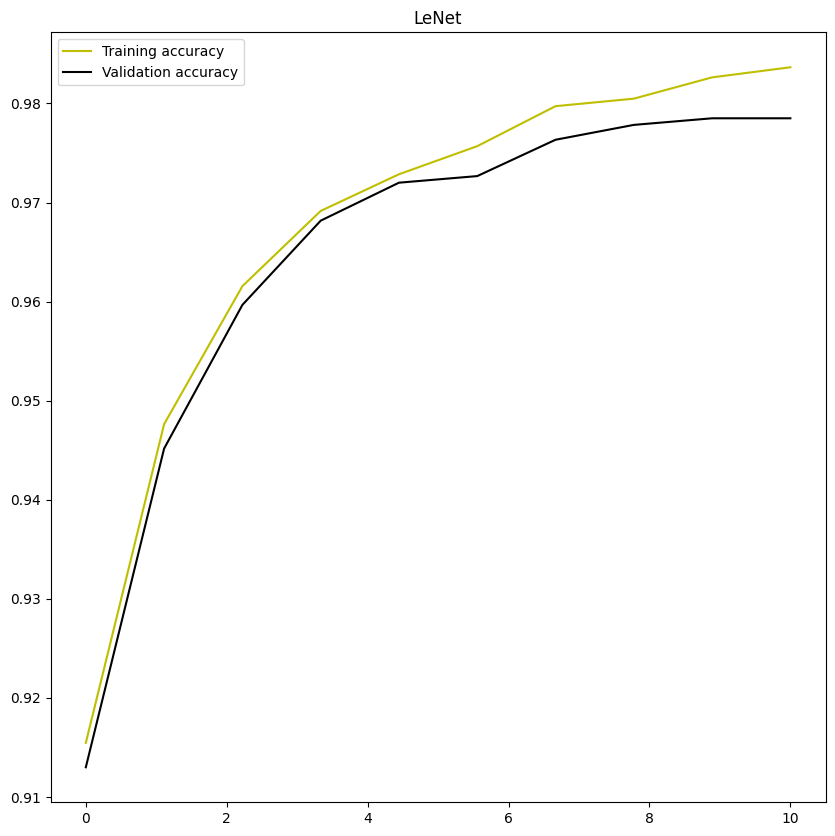

In [60]:
plt.figure(figsize = (10,10))
train_x = np.linspace(0, epochs_num, len(train_acc_logger))
plt.plot(train_x, train_acc_logger, c = "y")
valid_x = np.linspace(0, epochs_num, len(valid_acc_logger))
plt.plot(valid_x, valid_acc_logger, c = "k")

plt.title("LeNet")
plt.legend(["Training accuracy", "Validation accuracy"])

In [61]:
test_accuracy = evaluate(model, test_loader)
print(f'Test accuracy: {test_accuracy}')

Test accuracy: 0.9835


Predicted Values
 [7, 2, 1, 0, 4, 1, 4, 9]
True Values
 [7, 2, 1, 0, 4, 1, 4, 9]


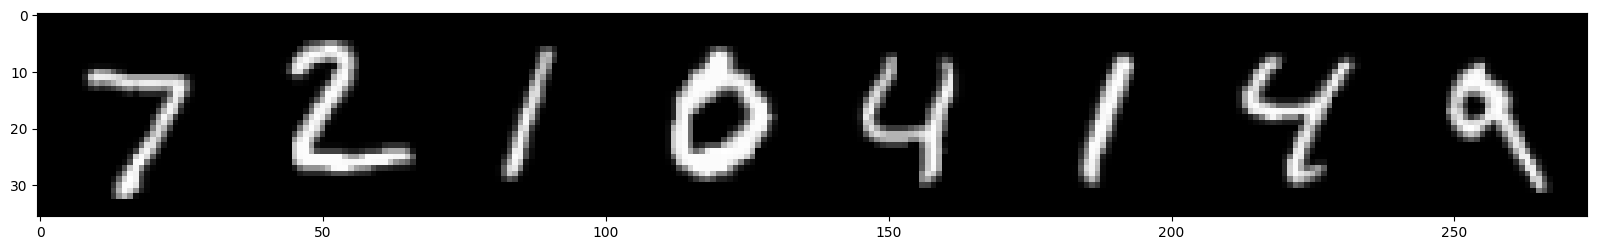

In [62]:
images_to_test = test_images[:8]
with torch.no_grad():
    forward_pass = model(images_to_test.to(device))
    class_pred = forward_pass.argmax(1)
    
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(images_to_test, 8, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

print("Predicted Values\n", list(class_pred.cpu().numpy()))
print("True Values\n", list(test_labels[:8].numpy()))